<a href="https://colab.research.google.com/github/lamantinushka/cam_summarisation/blob/master/MeanSum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction 
MeanSum [1] is an unsupervised approach to the multidocument summarisation task. It is proposed using Encoder-Decoder structure with reccurent models as both encoder and decoder. The main idea is to learn hidden representations that allow iterations in the latent space. In other words, mean of final hidden states of the documents from one query is expected to be a latent representation of a summary of this query.

Encoder and Decoder are trained simultaneously to minimize loss function that includes two components: reconstruction and summarisation losses. Reconstruction loss stimulated decoder to be able to restore input sequence from the final hidden state of the input sequence. It is a standart Cross-Entropy loss calculating with a teacher forcing. We normalize both losses by the number of sentences in the query so that stochastic gradients to be of the same range during optimisation.

$$\mathcal{L} = \mathcal{L}_r + \mathcal{L}_s$$
$$\mathcal{L}_r = \frac1{n}\sum_i CrossEntropy(d_i)$$

Summarisation loss allows to optimize iterations in the latent space. It penalizes summary for being different from each of the original documents. There is an obvious issue: we need a differentiable similarity function between generated sequence and input sequences. It is proposed to use cosine distance between final hidden states, so that we need to encode summary generated by decoder. For the sumarization loss to be differentiable we use he Straight Through Gumbel-Softmax trick [2] during decoding, which means that on everu decoding step we generate sample from the predicted probability distribution.

$$\mathcal{L}_s = \frac1{n}\sum_i (1 - \frac{\left<h_{mean}, h_i\right>}{\|h_{mean}\|\|h_i\|}) $$

Both encoder and decoder are proposed to be initialized by a pretrained language model. It also crucial that we are not able to use models with attention because it does not allow document representations to be averaged.


- [1] MeanSum : A Neural Model for Unsupervised Multi-Document Abstractive Summarization. Eric Chu & Peter J. Liu. https://arxiv.org/pdf/1810.05739.pdf
- [2] Categorical repa- rameterization with gumbel-softmax. Jang, E., Gu, S., and Poole, B. https://arxiv.org/pdf/1611.01144.pdf

# Loading data

In [0]:
import json

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
data = []
for line in open('drive/My Drive/summarization/mined_bow_str.json', 'r'):
    data.append(json.loads(line))

In [0]:
# usefull function that extracts all supporting sentences from the CAM output
def write_sentences(sample, sentences = None):
    if sentences is None:
        sentences = []
    for s in sample['object1']['sentences']:
        sentences.append(s['text'] + '\n')
    for s in sample['object2']['sentences']:
        sentences.append(s['text'] + '\n')
    return sentences

In [28]:
samples = [data[4], data[155], data[228]]

for s in samples:
  print(s['object1']['name'] + ' vs ' + s['object2']['name'])

python vs java
toyota vs nissan
tea vs juice


# Modeling
Here we define LSTM language model that will be used for both Encoder and Decoder initialization. We use pretrained embeddings as input representations as well as original BERT tokenizer. Our domain is pretty wide, but size of dataset is relatively small, so it is relevant to use BPE tokenization and pretrained ebeddings.

In [0]:
!pip install pytorch-pretrained-bert

In [0]:
import numpy as np
import torch
from pytorch_pretrained_bert import *
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, KLDivLoss
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased', do_lower_case=True)

BERTmodel = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    cache_dir='./model_cache',
    num_labels=2)#.to(device)

And let us train RNN Language Model with BERT embeddings

In [0]:
class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken, ninp = 768, nhid = 512, nlayers=1, dropout=0.5, tie_weights=False):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        #len, batch, hidden_size
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear( nhid, ntoken)

        self.init_weights()

        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden, input_lengths = None):
        emb = self.drop(self.encoder(input))
        if input_lengths is not None:
            emb = torch.nn.utils.rnn.pack_padded_sequence(emb, input_lengths, enforce_sorted = True)
            outputs, hidden = self.rnn(emb, hidden)
            output, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        else:
            output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        return decoded, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))
        

def detach_hidden(hidden):
    return (hidden[0].detach(),
            hidden[1].detach())

In [0]:
device = torch.device("cuda")
LM = RNNModel(30522, nlayers=2)
LM.encoder = BERTmodel.bert.embeddings.word_embeddings
LM = LM.to(device)

# Training

## Pretrain on WikiText103

WikiText103 is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. 

It also has a wide domain and can probably cover  most of the topics included in CAM answers queries. Still, it has a lot of out of the CAM domain texts, so pretraining is not guarantied to be efficient

In [0]:
path = 'drive/My Drive/summarization/wikitext-103/wiki.train.tokens'
with open(path, 'r', encoding="utf8") as f:
    wikilines = f.readlines()

textlines = []
for line in wikilines:
    if line != ' \n' and '=' not in line:
        textlines.append(line)

In [0]:
wiki_tokenized = []
for line in textlines:
    line = line.replace('<unk>', "[UNK]")
    tokens = ["[CLS]"] + tokenizer.tokenize(line) + ["[SEP]"]
    wiki_tokenized.append(tokenizer.convert_tokens_to_ids(tokens))

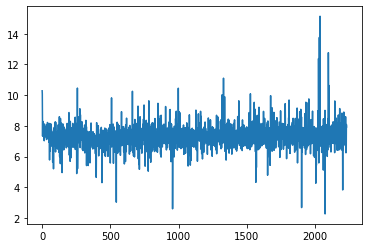

In [0]:
losses = []
n_epochs = 2
optimizer = torch.optim.Adam(LM.parameters(), lr = 3*1e-6)

for n in range(n_epochs):
    idxes = np.arange(len(wiki_tokenized))
    np.random.shuffle(idxes)
    criterion = CrossEntropyLoss(ignore_index=0 )
    i = 0
    for idx in idxes:
        i += 1
        batch = torch.tensor(wiki_tokenized[idx], device = device).view(-1, 1)
        hidden = LM.init_hidden(1)
        preds, hidden = LM(batch, hidden)
        loss = criterion(preds[:-1].reshape(-1, 30522), batch[1:].reshape(-1))
        loss.backward()
        optimizer.step()
        if i % 200 == 0:
            losses.append(loss.item())
            if i % 2000 == 0:
                clear_output(True)
                plt.plot(losses)
                plt.show()
                if i % 5000 == 0:
                    torch.save(LM.state_dict(), 'drive/My Drive/summarization/lm_wikitext')


In [0]:
torch.save(LM.state_dict(), 'drive/My Drive/summarization/lm_wikitext')

## Finetune

We can train language model on the sentences from CAM answers from scratch or use pretrained model on WikiText. As it was show, none of the models demonstrates good performance in summarization.

Prepare data for the language model training:

In [0]:
sentences = []
for sample in data:
  sentences = write_sentences(sample, sentences)

with open('sentences.txt', 'a') as file:
    file.writelines(sentences)

In [0]:
with open('drive/My Drive/summarization/sentences.txt', 'r') as file:
    lines = file.readlines()

Load or initialize model:

In [0]:
device = torch.device("cuda")
LM = RNNModel(30522, nlayers=2)
#LM.encoder = BERTmodel.bert.embeddings.word_embeddings
LM.load_state_dict(torch.load('drive/My Drive/summarization/lm_wikitext'))
LM = LM.to(device)

Train:

In [0]:
def iterate_batches(samples, batch_size):
    samples = np.array(samples)
    idxes = np.arange(len(samples))
    np.random.shuffle(idxes)
    for i in range(len(samples)//batch_size):
        start = i*batch_size
        end = (i+1)*batch_size
        batch = samples[idxes[start:end]]
        lengths = [len(s) for s in batch]
        length = max(lengths)
        order = np.argsort(lengths)[::-1]

        tensor = torch.zeros(batch_size, length, device = device, dtype = torch.long)
        for j, s in enumerate(batch[order]):
            tensor[j, :len(s)] = torch.as_tensor(np.array(s, dtype = np.long))

        yield tensor, np.array(lengths)[order]

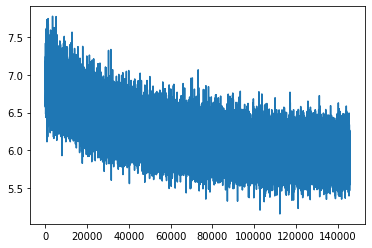

In [0]:
batch_size = 32
losses = []
n_epochs = 20
optimizer = torch.optim.Adam(LM.parameters(), lr = 3*1e-6)

for n in range(n_epochs):
    sampler = iterate_batches(samples, batch_size)
    criterion = CrossEntropyLoss(ignore_index=0 )
    i = 0
    for batch, lengths in sampler:
        i += 1
        batch = batch.transpose(0, 1)
        hidden = LM.init_hidden(batch_size)
        preds, hidden = LM(batch, hidden, input_lengths = lengths)
        loss = criterion(preds[:-1].reshape(-1, 30522), batch[1:].reshape(-1))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        if i % 100 == 0:
            clear_output(True)
            plt.plot(losses)
            plt.show()

In [0]:
torch.save(LM.state_dict(), 'drive/My Drive/summarization/wikitext_lm_finetuned')
#torch.save(LM.state_dict(), 'drive/My Drive/summarization/simple_lm')

## MeanSum training
In this section we train MeanSum model. We use pretrained language models as it is proposed in the paper. 

In [12]:
encoder = RNNModel(30522, nlayers=2, dropout=0.0).to(device)
decoder = RNNModel(30522, nlayers=2, dropout=0.0).to(device)

encoder.load_state_dict(torch.load('drive/My Drive/summarization/wikitext_lm_finetuned'))
decoder.load_state_dict(torch.load('drive/My Drive/summarization/wikitext_lm_finetuned'))

<All keys matched successfully>

Define function for differentiable summary generation:

In [0]:
def gen_sentence(decoder, hidden = None, maxlen = 50, temperature = 1.0):
    if hidden is None:
        hidden = decoder.init_hidden(1)
    tokens = torch.zeros(maxlen, device = device, dtype = torch.long)
    input = torch.LongTensor([tokenizer.convert_tokens_to_ids(["[CLS]"])]).to(device)
    for i in range(maxlen):
        output, hidden = decoder(input, hidden)
        word_weights = output.squeeze().div(temperature).exp().cpu()
        word_idx = torch.multinomial(word_weights, 1)[0]
        input.fill_(word_idx)
        tokens[i] = word_idx
        if input.item() == 102:
            return tokens[:i]
    return tokens

And MeanSum loss including reconstruction and summarisation components:

In [0]:
def compute_loss(tokenized_sentences):
    criterion = CrossEntropyLoss(ignore_index=0 )
    hiddens = []
    mean_h, mean_c = decoder.init_hidden(1)
    restoration_loss = 0.0
    for s in tokenized_sentences:
        hidden = encoder.init_hidden(1)
        batch = torch.LongTensor([s]).transpose(0, 1).to(device)
        _, h = encoder(batch, hidden)
        hiddens.append(h)
        mean_h += h[0]
        mean_c += h[1]

        preds, hidden = decoder(batch, h)
        restoration_loss += criterion(preds[:-1].reshape(-1, 30522), batch[1:].reshape(-1))

    mean_h /= len(hiddens)
    mean_c /= len(hiddens)
    summary = gen_sentence(decoder, hidden = (mean_h, mean_c), maxlen = 50, temperature = 1.0)
    hidden = encoder.init_hidden(1)
    _, encoded_h = encoder(summary.view(-1, 1), hidden)

    mean_loss = 0.0
    h_mean_norm = (encoded_h[0]**2).sum().pow(0.5)
    c_mean_norm = (encoded_h[1]**2).sum().pow(0.5)
    for h in hiddens:
        h_norm = (h[0]**2).sum().pow(0.5)
        c_norm = (h[1]**2).sum().pow(0.5)
        mean_loss += 1 - torch.sum(encoded_h[0] * h[0])/h_mean_norm/h_norm
        mean_loss += 1 -  torch.sum(encoded_h[1] * h[1])/c_mean_norm/c_norm

    return restoration_loss/len(hiddens), mean_loss/len(hiddens)

In [0]:
samples = []

for sample in data:
    lines = write_sentences(sample, [])
    tokenized_sentences = []
    for s in lines:
        s = ["[CLS]"] + tokenizer.tokenize(s) + ["[SEP]"]
        tokenized_sentences.append(tokenizer.convert_tokens_to_ids(s))
    samples.append(tokenized_sentences)

samples = [s for s in samples if len(s)!=0]

In [0]:
r_loss = []
m_loss = []

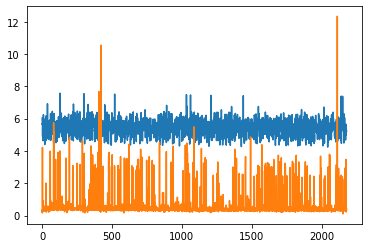

KeyboardInterrupt: ignored

In [22]:
encoder.train()
decoder.train()
#optimizer_e = torch.optim.Adam(encoder.parameters(), lr = 1e-5)
#optimizer_d = torch.optim.Adam(decoder.parameters(), lr = 1e-5)
n_epochs = 3
C = 5.0

for n in range(n_epochs):
    idxes = np.arange(len(samples))
    np.random.shuffle(idxes)
    for idx in idxes:
        tokenized_sentences = samples[idx]
        rl, ml = compute_loss(tokenized_sentences)
        r_loss.append(rl.item())
        m_loss.append(ml.item()*C)

        loss = rl + ml*C
        loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)
        optimizer_e.step()
        optimizer_d.step()

        clear_output(True)
        plt.plot(r_loss)
        plt.plot(m_loss)
        plt.show()

In [0]:
torch.save(encoder.state_dict(), 'drive/My Drive/summarization/encoder_wikitext')
torch.save(decoder.state_dict(), 'drive/My Drive/summarization/decoder_wikitext')

# Inference

For the final summary generation we can use both soft and hard generation function. Here we define a hard generation function that chooses the most probable token on each step.

Still none of the methods gives informative and smooth summaries. 

Comparing our data to the one MeanSum algorithm was used in original paper, we can see that their domain was much smaller including only restarauns reviews. The reviews also often contained more than one sentence, so that decoder was not forced to end sequence generation after end of sentence as it happened in our case.

In [0]:
encoder.load_state_dict(torch.load('drive/My Drive/summarization/encoder_wikitext'))
decoder.load_state_dict(torch.load('drive/My Drive/summarization/decoder_wikitext'))

In [0]:
def gen_sentence_hard(decoder, hidden = None, maxlen = 50):
    if hidden is None:
        hidden = decoder.init_hidden(1)
    tokens = torch.zeros(maxlen, device = device, dtype = torch.long)
    input = torch.LongTensor([tokenizer.convert_tokens_to_ids(["[CLS]"])]).to(device)
    for i in range(maxlen):
        output, hidden = decoder(input, hidden)
        word_weights = output.squeeze()
        word_idx = torch.argmax(word_weights)
        input.fill_(word_idx)
        tokens[i] = word_idx
        if input.item() == 102:
            return tokens[:i]
    return tokens

In [0]:
def summarize(tokenized_sentences, hard = True):
    mean_h, mean_c = decoder.init_hidden(1)
    for s in tokenized_sentences:
        hidden = encoder.init_hidden(1)
        batch = torch.LongTensor([s]).transpose(0, 1).to(device)
        _, h = encoder(batch, hidden)
        mean_h += h[0]
        mean_c += h[1]

    mean_h /= len(tokenized_sentences)
    mean_c /= len(tokenized_sentences)
    if hard:
        summary = gen_sentence_hard(decoder, hidden = (mean_h, mean_c), maxlen = 50)
    else:
        summary = gen_sentence(decoder, hidden = (mean_h, mean_c), maxlen = 50, temperature = 1.0)
    return summary

In [35]:
for sample in samples:
    sentences = write_sentences(sample)
    tokenized_sentences = []
    for s in sentences:
        tokens = ["[CLS]"] + tokenizer.tokenize(s) + ["[SEP]"]
        tokenized_sentences.append(tokenizer.convert_tokens_to_ids(tokens))
    tokens = summarize(tokenized_sentences, hard = False)
    summ = ' '.join(tokenizer.convert_ids_to_tokens(tokens.cpu().detach().numpy()))
    summ = summ.replace(' ##', '')
    print(sample['object1']['name'] + ' vs ' + sample['object2']['name'] + ':')
    print(summ)
    print()

python vs java:
new use was stronger some significant , loaded , best action than google .

toyota vs nissan:
same michigan over wood years of survival over microsoft .

tea vs juice:
handheld as .

